# To run this script, it must be in the same floder with all the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed  # For parallel computing
from tqdm import tqdm                 # For Display the progress
from simulated_data import*
from plotnine import*
# from stochastic_epidemic_model import seir_model_const, seir_model_var, stochastic_model_covid
from particle_filter import Kernel_Smoothing_Filter
from trace_plot import trace_smc, trace_smc_covid, plot_smc, plot_smc_covid

In [2]:
# pip install plotnine 

## Sequential Monte Carlo for state and Parameters estimation

- The following codes generate the dataset and SMC code itself using kernel density estimation
- The SMC code is apply in a context of infectious diseases.

### Generate the simulated data set on infectious diseases with time-varying transmission rate

In [3]:
true_theta = [0.5, 1/4,1/5]
N_pop = 6000
InitialState_example = [0, N_pop-1, 0, 1, 0, 0, 0.5] # ['t','S','E','I','R','CI','B']
t_start = 0
t_end = 120
dt = 1

# Specify the seed for reproductibility
np.random.seed(123)
results_example =  solve_seir_var_beta(seir_var_beta, true_theta, InitialState_example, t_start, t_end, dt)
simulated_data = pd.DataFrame({'time': results_example['time'], 'obs': results_example['NI'], 'Bt': results_example['Bt']})

### Define your SEIR model

In [4]:

# This model with with beta following geometric random walk can track multiple wave epidemic
def seir_model_var(y, theta, theta_names, dt=1):
    """
    Discrete-time stochastic SEIR model.

    Parameters:
    - y: Vector of variables [S, E, I, R, NI, B]
            S: susceptible
            E: Exposed
            I: Infected
            R: Recovered
            NI: New infected  (used to link with the observations)
            B: Time-varying transmission rate
    - theta: Set of parameters
    - theta_names: Name of the parameters:
            sigma: Latency rate
            gamma: Recovery rate
            v_beta: volatility transmission rate ( default square value)

    Returns:
    - y_next: Updated vector of variables [S, E, I, R, NI, B]
    """

    # Unpack variables
    S, E, I, R, NI, B= y
    N = S + E + I + R

    # Unpack parameters
    param= dict(zip(theta_names,theta))
   

    # Binomial distributions for transitions
    P_SE = 1 - np.exp(-B * I / N * dt)  # Probability of transition from S to E
    P_EI = 1 - np.exp(-param['sigma'] * dt)      # Probability of transition from E to I
    P_IR = 1 - np.exp(-param['gamma'] * dt)      # Probability of transition from I to R

    # Binomial distributions for transitions
    B_SE = np.random.binomial(S, P_SE)
    B_EI = np.random.binomial(E, P_EI)
    B_IR = np.random.binomial(I, P_IR)

    # Update the compartments
    S += -B_SE
    E += B_SE - B_EI
    I += B_EI - B_IR
    R += B_IR
    B *= np.exp( param['v_beta']**0.5* np.random.normal(0, 1) * dt) 
    # or np.exp( param['v_beta']* np.random.normal(0, 1) * dt)  depending on prior on v_beta is square value or not
    
    NI= B_EI

    y_next = [max(0, compartment) for compartment in [S, E, I, R,  NI, B]] # Ensure non-negative elements

    return y_next

## Run Kernel Density Particle Filter

In [5]:

state_info = {
        'S': {'prior': [N_pop - 5, N_pop, 0, 0, 'uniform']},  
        'E': {'prior': [0, 0, 0, 0, 'uniform']},
        'I': {'prior': [0, 5, 0, 0, 'uniform']},
        'R': {'prior': [0, 0, 0, 0, 'uniform']},
        'NI': {'prior': [0, 0, 0, 0, 'uniform']},
        'B': {'prior': [0.3, 0.6, 0,0, 'uniform']}
}


theta_info = {
    'sigma': {'prior': [1/14, 1/2,0,0, 'uniform']},
    'gamma': {'prior': [1/15, 1/2,0,0, 'uniform']},
    'v_beta': {'prior': [20, 0.03,0,0, 'invgamma'] } # This is squared value of v_beta

}



# Run Particle Filter
results_filter =  Kernel_Smoothing_Filter(
    model=seir_model_var, 
    initial_state_info=state_info , 
    initial_theta_info=theta_info , 
    observed_data=simulated_data,
    population_size=N_pop,
    num_particles=10000,
    resampling_method='stratified',
    observation_distribution='poisson', 
    show_progress=True
)


print("Marginal log_likelihood=", results_filter['margLogLike'])


Particle Filter Progress: 100%|███████████████| 121/121 [25:02<00:00, 12.42s/it]

Marginal log_likelihood= -382.62470651147913


## IV.2-  Plot the solution

#### Plot Trajectories

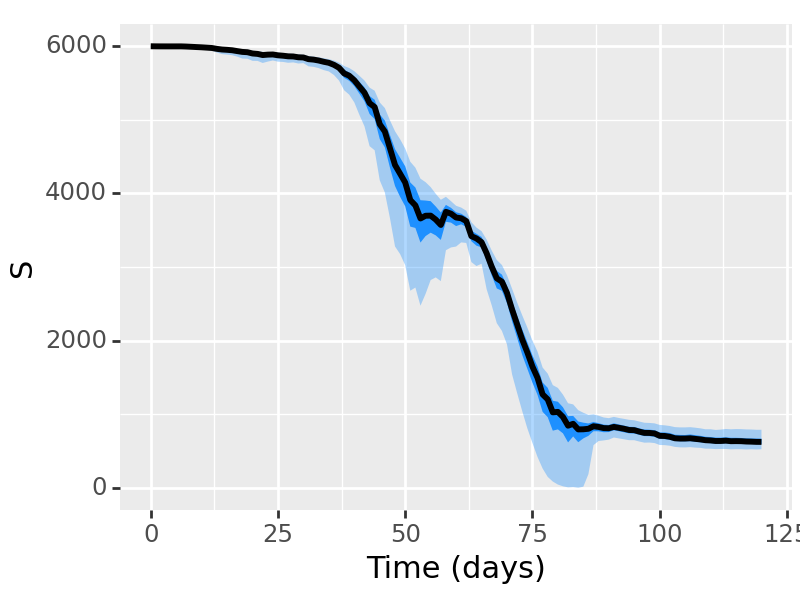

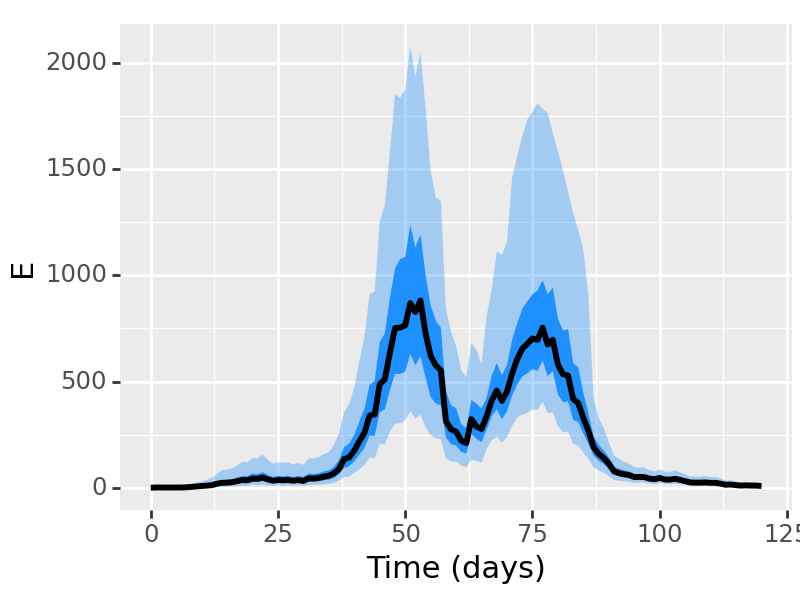

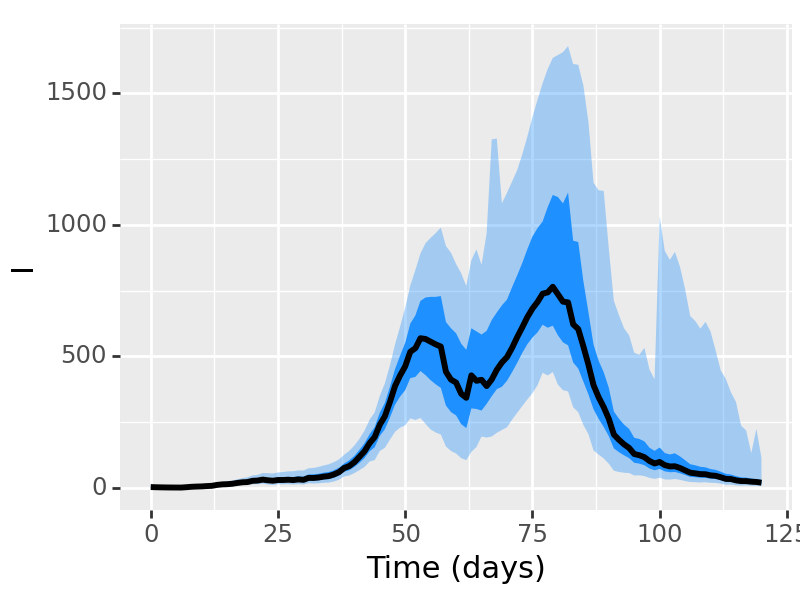

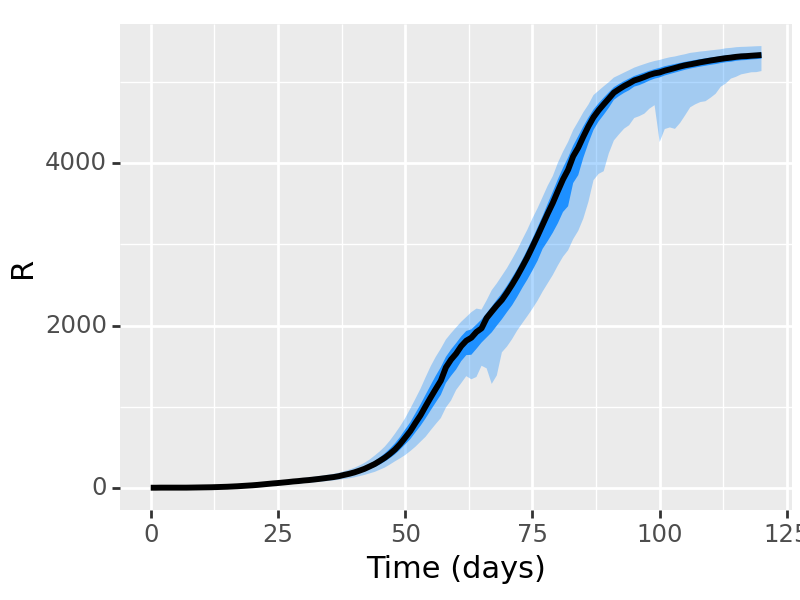

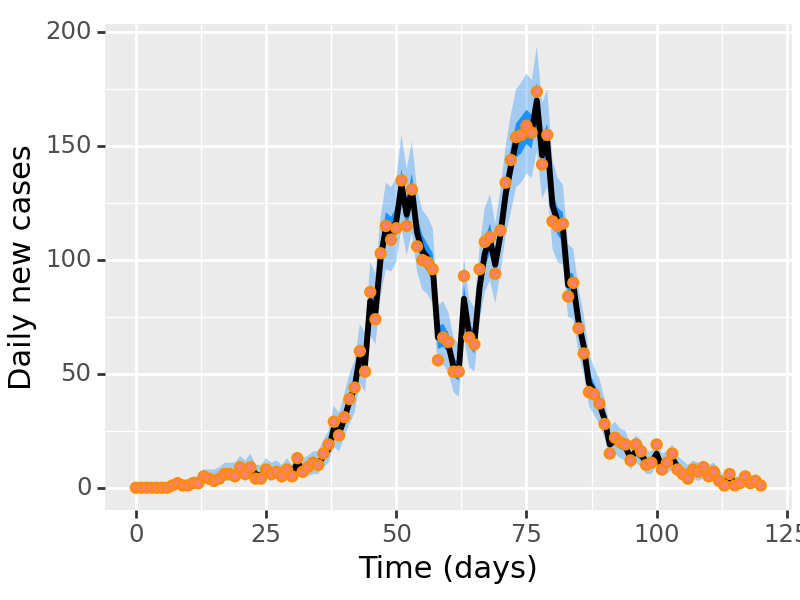

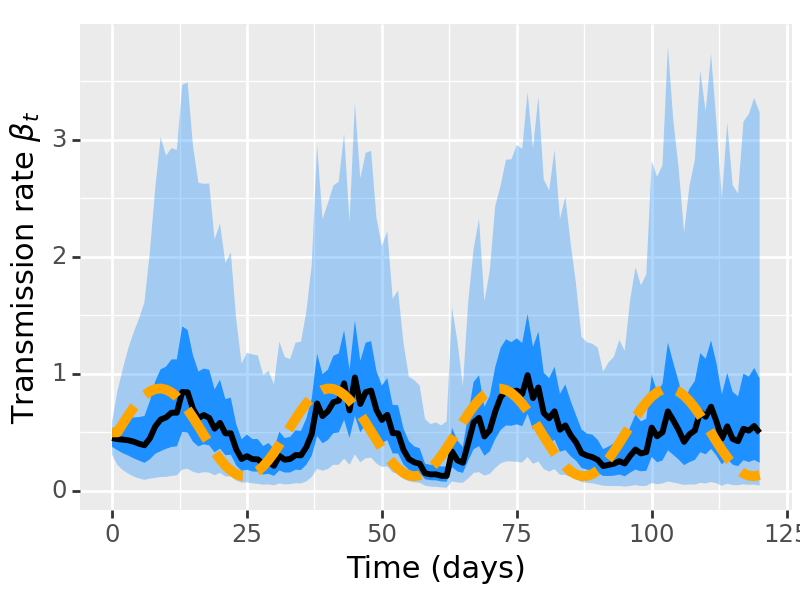

In [6]:
# Plot of the states

trajParticles = results_filter['trajState']
matrix_dict = trace_smc(trajParticles)

# Iterate through each key-value pair in matrix_diJe confime quoi?ct and plot in a subplot
for (state, matrix) in matrix_dict.items():
    p = plot_smc(matrix) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
    if state == 'NI':
        p +=geom_point(aes(x=simulated_data['time'], y=simulated_data['obs']),fill='salmon', color='darkorange', size=1.5)
        p += ylab("Daily new cases") 
    elif state == 'B':
        p += geom_line(aes(x=simulated_data['time'], y=simulated_data['Bt']), color='orange', linetype='dashed',size=2)
        p += ylab(r'Transmission rate $\beta_t$') 
    else:
        p += ylab(state)
    
    p += xlab("Time (days)")
    p += theme(figure_size=(4,3))
    print(p)  # Print or display the plot


#### Plot paramater densities

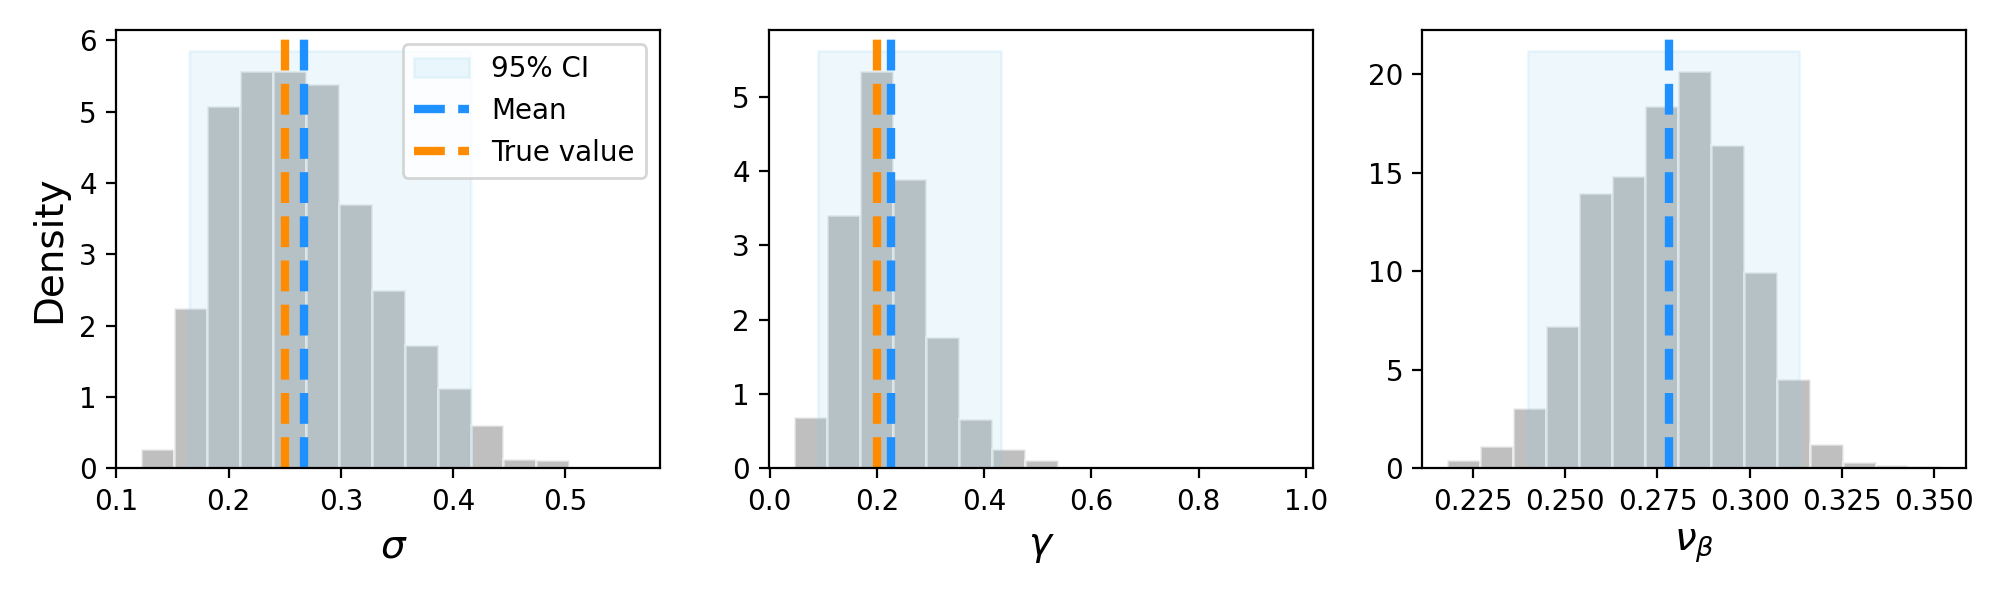

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

trajParticles = results_filter['trajtheta']
matrix_dict = trace_smc(trajParticles)
# Number of subplots needed
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3))  # 1 row, 4 columns of plots

# Flatten axes to iterate easily
axes = axes.flatten()
L = [r' $\sigma$', r'$\gamma$', r'$\nu_{\beta}$']

for i, (state, matrix) in enumerate(matrix_dict.items()):
    if state=='v_beta':
        matrix=np.sqrt(matrix)
    mean_value = np.mean(matrix[:, -1])
    data = matrix[:, -1]
    
    # Plot histogram
    axes[i].hist(data, bins=15, density=True, alpha=0.5, color='gray', edgecolor='white')
    
    # Compute and plot density using gaussian_kde
    kde = gaussian_kde(data, bw_method=0.3)
    x_vals = np.linspace(data.min()-0.01, data.max()+0.01, 1000)
    kde_vals = kde(x_vals)
    # axes[i].plot(x_vals, kde_vals, color='b', lw=1.5)
    
    # Calculate the 95% credible interval (2.5th and 97.5th percentiles)
    lower_bound, upper_bound = np.percentile(data, [2.5, 97.5])
    
    # Set y-limit to extend the shaded area to infinity (or ymax)
    ymax_hist = axes[i].get_ylim()[1]  # Get the current max y-limit of the axis
    
    # Fill the area between the 95% credible interval, extending the shading to ymax (infinity concept)
    axes[i].fill_between(x_vals, 0, ymax_hist, where=((x_vals >= lower_bound) & (x_vals <= upper_bound)), 
                         color='skyblue', alpha=0.15, label='95% CI')

    # Plot vertical line at mean_value
    axes[i].axvline(mean_value, color='dodgerblue', linestyle='dashed', lw=3, label='Mean')
    
    # Plot vertical orange line for true values
    if i < 2:
        axes[i].axvline(true_theta[i + 1], color='darkorange', linestyle='dashed', lw=3, label = 'True value')
    
    # Set labels
    axes[i].set_xlabel(L[i], size=14)
    if i < 1:
        axes[i].set_ylabel('Density', size=14)
        axes[i].legend()
   

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


#### Plot parameters

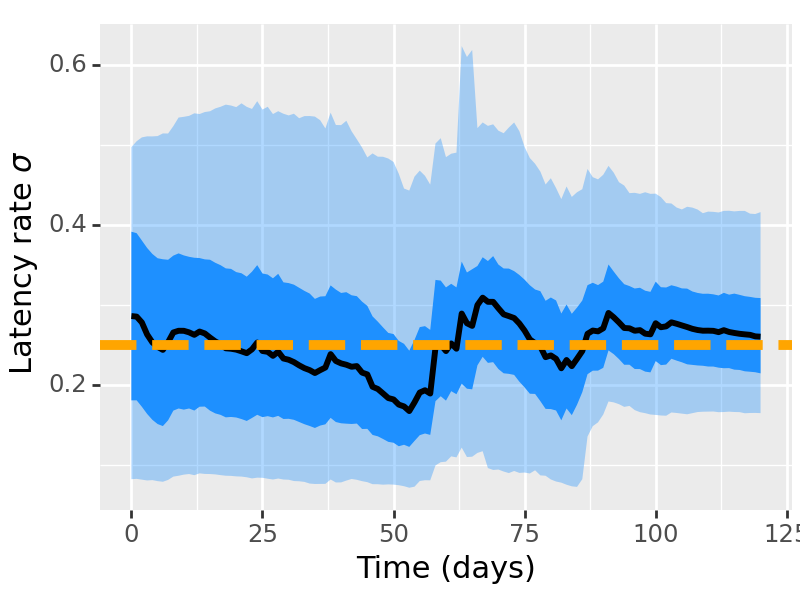


95 NI [0.16486782 0.4159974 ]
median 0.26036255901987265
mean 0.2671156458434491
std 0.06703262880481854


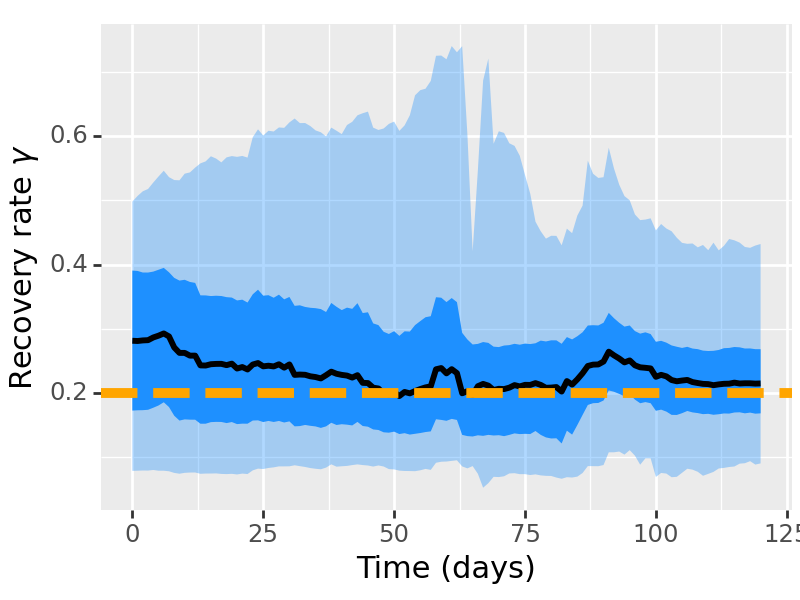


95 NI [0.08979364 0.43194571]
median 0.21450147567353262
mean 0.22623034141063908
std 0.09008017890665793


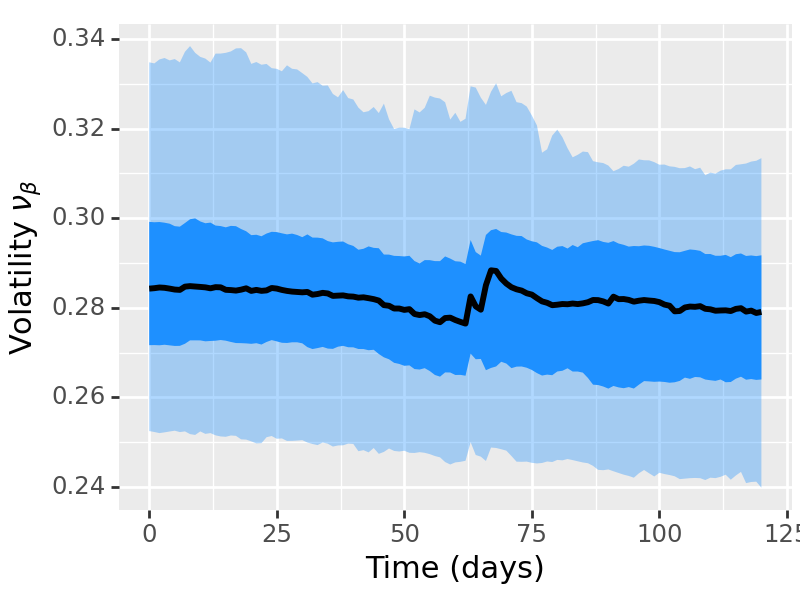


95 NI [0.23979955 0.31342572]
median 0.27907830067224654
mean 0.27814528282025147
std 0.01926479856147463


In [8]:

# Assuming you have simulated_data DataFrame with 'time' and 'obs' columns
plt.rcParams['text.usetex'] = False

L = [r' Latency rate $\sigma$', r'Recovery rate $\gamma$', r'Volatility $\nu_{\beta}$','ov']
# Plot of the parameters
trajParticles = results_filter['trajtheta']
matrix_dict = trace_smc(trajParticles)


# Iterate through each key-value pair in matrix_dict and plot in a subplot
for i, (state, matrix) in enumerate(matrix_dict.items()):
    if state=='v_beta':
        matrix=np.sqrt(matrix)
    p = plot_smc(matrix) # use plot_smc(matrix, CI_50=False, CI_95=False) if you don't want the 50% or 95% CI to appear 
    if i < 2:
        p +=geom_hline(yintercept=true_theta[i+1], color='orange', linetype='dashed', size=2)
    p += theme(figure_size=(4,3))
    p+= ylab(L[i])
    p += xlab("Time (days)")
    print(p)
    print('95 NI',np.percentile(matrix[:,-1], [2.5, 97.5]))
    print('median', np.median(matrix[:,-1]))
    print('mean',np.mean(matrix[:,-1]))
    print('std',np.std(matrix[:,-1]))

